In [1]:
%matplotlib inline
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


<b>Question 1:

We first create a symbolic link on this package into our working/current directory, then save declare variable dataset_root_dir

In [3]:
dataset_root_dir= "./datasets/"

<b>Question 2:

In [4]:
class BirdsDataset(td.Dataset):
    def __init__(self, root_dir, mode="train", image_size=(224, 224)):
        super(BirdsDataset, self).__init__()
        self.image_size = image_size
        self.mode = mode
        self.data = pd.read_csv(os.path.join(root_dir, "%s.csv" % mode))
        self.images_dir = os.path.join(root_dir, "CUB_200_2011/images")
        
    def __len__(self):
        return len(self.data)
    
    def __repr__(self):
        return "BirdsDataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, \
        self.data.iloc[idx]['file_path'])
        bbox = self.data.iloc[idx][['x1', 'y1', 'x2', 'y2']]
        img = Image.open(img_path).convert('RGB')
        img = img.crop([bbox[0], bbox[1], bbox[2], bbox[3]])
        transform = tv.transforms.Compose([
        transforms.Resize(self.image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])    
        
        x = transform(img)
        d = self.data.iloc[idx]['class']
        return x, d
    
    def number_of_classes(self):
        return self.data['class'].max() + 1

<b>Question 3:

In [5]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

Label: 0


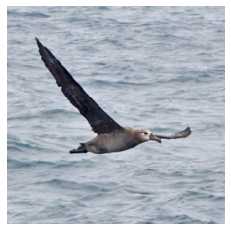

In [61]:
train_set = BirdsDataset(dataset_root_dir,mode='train')
x,d = train_set[10]
plt.figure()
myimshow(x)
print('Label:',d)

<b>Question 4:

In [7]:
train_loader = DataLoader(train_set, batch_size=16, shuffle=True,pin_memory=True)

For data loading, passing pin_memory=True to a DataLoader will automatically put the fetched data Tensors in pinned memory, and thus enables faster data transfer to CUDA-enabled GPUs. As most of the time dataset is loaded in the cpu, using pin_memory = True, lets your DataLoader allocate the samples in page-locked memory, which speeds-up the transfer.

In [8]:
count = 0
for data in train_loader:
    count = count +1;
    
print('Number of Mini-batches:',count)

Number of Mini-batches: 47


Hence, number of mini-batches = 47.

<b>Question 5:

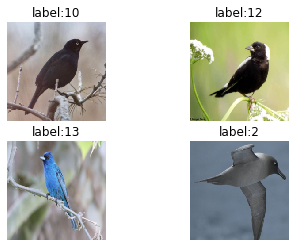

In [51]:
i=1
for data in train_loader:
    img, label = data
    l = label[0].numpy()
    plt.subplot(2,2,i)
    titl = 'label:'+str(l)
    myimshow(img[0])
    plt.title(titl)
    i=i+1
    
    if i==5:
        break

We observe that everytime we run the cell, new 4 pics are displayed. This points to the fact that everytime a random minibatch is choosen for training. This is done to ensure better convergence of the optimizer.

<b>Question 6:

In [10]:
val_set = BirdsDataset(dataset_root_dir,mode='val')
val_loader = DataLoader(val_set, batch_size=16, pin_memory=True, shuffle=False)

For training, choosing random inputs is important. This prevents overfiting and ensures better convergence. It helps to model to learn generalized features and reduced the generalized error. While, during the validation/testing phase, the order in which prediction are made isn't important, rather the accuracy is important. Hence, we do not initiate random shuffling during validation

<b>Question 7:

In [11]:
import nntools as nt

In [12]:
net = nt.NeuralNetwork()

TypeError: Can't instantiate abstract class NeuralNetwork with abstract methods criterion, forward

It gives error. An abstract class does not implement all of its methods and cannot be instantiated. We need to define a network architecture, loss criterion, pass it to the abstract class NeuralNetwork().

In [62]:
class NNClassifier(nt.NeuralNetwork):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()
    def criterion(self, y, d):
        return self.cross_entropy(y, d)

<b>Question 8: VGG transfer learning

In [63]:
vgg = tv.models.vgg16_bn(pretrained=True)

<b>Printing the network

In [64]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

<b>Printing the learnable paramteres

In [65]:
for name, param in vgg.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

<b>Question 9:

In [66]:
class VGG16Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=True):
        super(VGG16Transfer, self).__init__()
        vgg = tv.models.vgg16_bn(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        self.classifier = vgg.classifier
        
        num_ftrs = vgg.classifier[6].in_features
        self.classifier[6] = nn.Linear(num_ftrs, num_classes)

        
    def forward(self, x):
        # COMPLETE
        f = self.features(x)
        f = self.avgpool(f)
        f = f.view(-1, self.num_flat_features(f))
        y = self.classifier(f)
        return y
    
    def num_flat_features(self, x ):
        size = x.size()[1:]
        return np.prod(size)

<b>Question 10:

In [67]:
num_classes = train_set.number_of_classes()

<b>Printing the network

In [68]:
net = VGG16Transfer(num_classes);
print(net)

VGG16Transfer(
  (cross_entropy): CrossEntropyLoss()
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

<b>Learnable parameters

In [69]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

features.0.weight torch.Size([64, 3, 3, 3]) True
features.0.bias torch.Size([64]) True
features.1.weight torch.Size([64]) True
features.1.bias torch.Size([64]) True
features.3.weight torch.Size([64, 64, 3, 3]) True
features.3.bias torch.Size([64]) True
features.4.weight torch.Size([64]) True
features.4.bias torch.Size([64]) True
features.7.weight torch.Size([128, 64, 3, 3]) True
features.7.bias torch.Size([128]) True
features.8.weight torch.Size([128]) True
features.8.bias torch.Size([128]) True
features.10.weight torch.Size([128, 128, 3, 3]) True
features.10.bias torch.Size([128]) True
features.11.weight torch.Size([128]) True
features.11.bias torch.Size([128]) True
features.14.weight torch.Size([256, 128, 3, 3]) True
features.14.bias torch.Size([256]) True
features.15.weight torch.Size([256]) True
features.15.bias torch.Size([256]) True
features.17.weight torch.Size([256, 256, 3, 3]) True
features.17.bias torch.Size([256]) True
features.18.weight torch.Size([256]) True
features.18.bi

This is as we expected. We only changed the last layer of the classifier and freeze the above layers to retain the trained weights of original VGG18 net

<b>Question 11:

In [70]:
class ClassificationStatsManager(nt.StatsManager):
    def __init__(self):
        super(ClassificationStatsManager, self).__init__()
        
    def init(self):
        super(ClassificationStatsManager, self).init()
        self.running_accuracy = 0
        
    def accumulate(self, loss, x, y, d):
        super(ClassificationStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        self.running_accuracy += torch.mean((l == d).float())
        
    def summarize(self):
        loss = super(ClassificationStatsManager, self).summarize()
        # COMPLETE
        accuracy = 100 * self.running_accuracy/self.number_update
        return {'loss': loss, 'accuracy': accuracy}

<b>Question 12:

The "eval" mode is used when we want to test of learned network on a validation/testing set. Calling the eval() mode, disables the backpropagation to save computation, just forward passing is done to get the output of the network. Also, dropout and batch normalization layers are set to evaluation mode before running inference.

<b>Question 13:

In [72]:
lr = 1e-3
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
            output_dir="birdclass1", perform_validation_during_training=True)

A directory "birdclass1" was created in the current directory. When inspected, it had 2 files, checkpoint.pth.tar and config.txt. checkpoint.pth.tar a binary file containing the state of the experiment, and config.txt an ASCII file describing the setting of the experiment.

A common PyTorch convention is to save models using either a .pt or .pth file extension. Similar to pytorch functions, when saving a model, it is only necessary to save the trained model’s learned parameters. Saving the model’s state_dict with the torch.save() function will give you the most flexibility for restoring the model later, which is why it is the recommended method for saving models. 

<b>Question 14:

In [23]:
lr = 1e-4
net = VGG16Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp1 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
            output_dir="birdclass1", perform_validation_during_training=True)

ValueError: Cannot create this experiment: I found a checkpoint conflicting with the current setting.

As the documentation states, If ``output_dir`` does not exist, it will be created. Otherwise, the last checkpoint will be loaded, except if the setting does not match (in that case an exception will be raised). In the previous question, we initiated exp1 with learning rate = 1e-3. A directory was hence created with all network description. 

In this question we initiate exp1 again, and as a directory is already saved, the function loads the previous checkpoint. Now, as we changed the learning rate this time, a mis-match was found to the previous network setting. Hence, an expception was raised.

When we change the learning rate to 1e-3 and run the cell again, the last checkpoint is succesfully loaded.

<b>Question 15:

In [24]:
def plot(exp, fig, axes):
    axes[0].clear()
    axes[1].clear()
    axes[0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)],
    label="training loss")
    axes[0].plot([exp.history[k][1]['loss'] for k in range(exp.epoch)],
    label="Validation loss")
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend(('Training','Validation'),loc="upper right")


    
    axes[1].plot([exp.history[k][0]['accuracy'] for k in range(exp.epoch)],
    label="training accuracy")
    axes[1].plot([exp.history[k][1]['accuracy'] for k in range(exp.epoch)],
    label="Validation accuracy")
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend(('Training','Validation'),loc="lower right")


    plt.tight_layout()
    fig.canvas.draw()

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp1.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

Start/Continue training from epoch 0
Epoch 1 (Time: 32.81s)
Epoch 2 (Time: 32.21s)


<b>Question16: ResNET

In [26]:
res = tv.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /tmp/xdg-cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 70.6MB/s]


<b>Printing the ResNET18 network

In [28]:
num_ftrs = res.fc.in_features

In [29]:
class Resnet18Transfer(NNClassifier):
    def __init__(self, num_classes, fine_tuning=False):
        super(Resnet18Transfer, self).__init__()
        res = tv.models.resnet18(pretrained=True)
        for param in res.parameters():
            param.requires_grad = fine_tuning
        
        self.conv1 = res.conv1
        self.bn1 = res.bn1
        self.relu = res.relu
        self.maxpool = res.maxpool
        self.layer1 = res.layer1
        self.layer2 = res.layer2
        self.layer3 = res.layer3
        self.layer4 = res.layer4
        self.avgpool = res.avgpool
        
        num_ftrs == res.fc.in_features
        self.fc =  nn.Linear(num_ftrs,num_classes)

        
    def forward(self, x):
        f = self.conv1(x)
        f = self.bn1(f)
        f = self.relu(f)
        f = self.maxpool(f)
        f = self.layer1(f)
        f = self.layer2(f)
        f = self.layer3(f)
        f = self.layer4(f)
        f = self.avgpool(f)
        f = f.view(-1, self.num_flat_features(f))
        y = self.fc(f)
        return y
    
    def num_flat_features(self, x ):
        size = x.size()[1:]
        return np.prod(size)

In [30]:
num_classes = train_set.number_of_classes()

<b>Printing our network based on ResNET

In [31]:
net = Resnet18Transfer(num_classes);
print(net)

Resnet18Transfer(
  (cross_entropy): CrossEntropyLoss()
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

<b>Inspecting learnable parameters

In [32]:
for name, param in net.named_parameters():
    print(name, param.size(), param.requires_grad)

fc.weight torch.Size([20, 512]) True
fc.bias torch.Size([20]) True


<b>Question 17

In [33]:
lr = 1e-3
net = Resnet18Transfer(num_classes)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = ClassificationStatsManager()
exp2 = nt.Experiment(net, train_set, val_set, adam, stats_manager,
            output_dir="birdclass2", perform_validation_during_training=True)

Start/Continue training from epoch 0
Epoch 1 (Time: 26.61s)
Epoch 2 (Time: 26.46s)
Epoch 3 (Time: 27.00s)
Epoch 4 (Time: 26.95s)
Epoch 5 (Time: 26.71s)
Epoch 6 (Time: 26.80s)
Epoch 7 (Time: 26.77s)
Epoch 8 (Time: 26.67s)
Epoch 9 (Time: 26.09s)
Epoch 10 (Time: 27.01s)
Epoch 11 (Time: 26.86s)
Epoch 12 (Time: 26.29s)
Epoch 13 (Time: 26.77s)
Epoch 14 (Time: 26.69s)
Epoch 15 (Time: 26.98s)
Epoch 16 (Time: 27.32s)
Epoch 17 (Time: 26.98s)
Epoch 18 (Time: 26.97s)
Epoch 19 (Time: 26.88s)
Epoch 20 (Time: 27.09s)
Finish training for 20 epochs


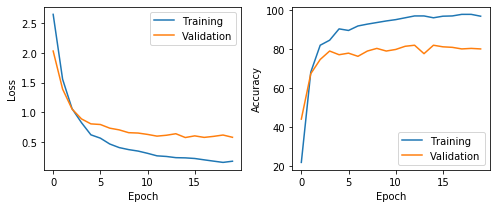

In [34]:
fig, axes = plt.subplots(ncols=2, figsize=(7, 3))
exp2.run(num_epochs=20, plot=lambda exp: plot(exp, fig=fig, axes=axes))

<b>Question 18:

Now, we compare the performance of validation for both the experiments 1 and 2. We use the evaluate method of experiment for this purpose.

In [45]:
print('Validation performance by exp1', exp1.evaluate())
print('\n')
print('Validation performance by exp1', exp2.evaluate())

Validation performance by exp1 {'loss': 0.528190954223923, 'accuracy': tensor(83.9674, device='cuda:0')}


Validation performance by exp1 {'loss': 0.576461189466974, 'accuracy': tensor(80.1630, device='cuda:0')}


We can see that exp1 has less loss and higher accuracy on the validation set after 20 epochs. Hence, this shows for this task, using transfer learning using VGG16 gave better results than ResNET18.